## Carga de librerías



In [3]:
# !pip install gensim

In [1]:


import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

nltk.download('stopwords')
stopwords_es = stopwords.words('spanish')
vectorizer = CountVectorizer(stop_words=stopwords_es)

# from google.colab import drive
# drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jresendiz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pln_datasources/Tweets.csv", on_bad_lines='skip') #vamos a cargar el archivo que contiene inconsistencias
df = pd.read_csv("./datasets/nlp/Tweets.csv",
                 on_bad_lines='skip')  #vamos a cargar el archivo que contiene inconsistencias

In [3]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## Vamos hacer una inspección inicial de los datos - EDA

In [4]:
# Imprime el tamaño inicial del DataFrame, es decir, el número de filas y columnas que tiene antes de hacer cualquier cambio
print("Tamaño inicial:", df.shape)

# Imprime cuántas veces aparece cada valor en la columna 'sentiment' (por ejemplo: positivo, negativo, neutral)
# Esto es útil para ver si las clases están balanceadas o si hay más datos de una clase que de otra
print(df['sentiment'].value_counts())


Tamaño inicial: (27481, 4)
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


In [5]:
# Imprime el número de valores nulos (NaN) que hay en cada columna del DataFrame
# Esto te ayuda a detectar si hay datos faltantes que podrían afectar el análisis o el modelo
print("\nValores nulos:\n", df.isnull().sum())

# Elimina filas que tengan valores nulos en las columnas 'text' o 'sentiment'
# Luego elimina filas duplicadas basándose únicamente en el contenido de la columna 'text'
# Finalmente, reinicia los índices del DataFrame para que queden consecutivos (drop=True evita que se guarde la columna vieja del índice)
df = df.dropna(subset=['text', 'sentiment']).drop_duplicates('text').reset_index(drop=True)

# Imprime el nuevo tamaño del DataFrame después de la limpieza
print("Después limpieza:", df.shape)



Valores nulos:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Después limpieza: (27480, 4)


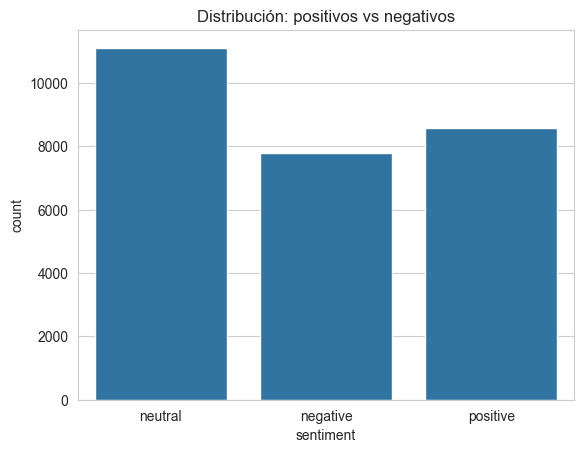

In [6]:
# Crea un gráfico de barras que muestra cuántas instancias hay de cada clase en la columna 'sentiment'
# Por ejemplo, cuántos textos son positivos, negativos, etc.
sns.countplot(x='sentiment', data=df)

# Agrega un título al gráfico para indicar que está mostrando la distribución de clases
plt.title("Distribución: positivos vs negativos")

# Muestra el gráfico en pantalla
plt.show()


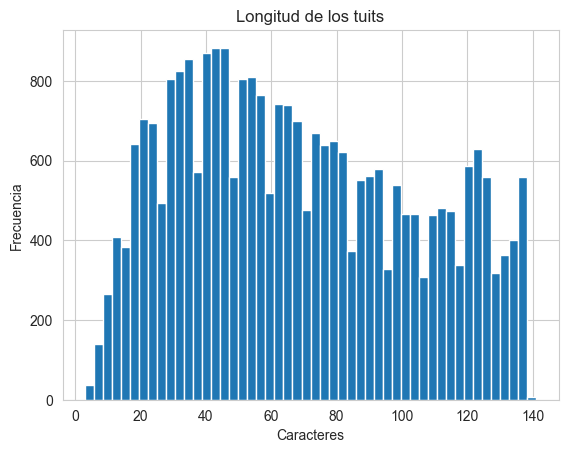

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: length, dtype: float64


In [7]:
# Crea una nueva columna llamada 'length' que contiene la longitud (número de caracteres) de cada texto en la columna 'text'
df['length'] = df['text'].str.len()

# Genera un histograma con 50 barras (bins), que muestra la distribución de longitudes de los textos
# Esto permite ver si la mayoría de los textos son cortos, largos o variados
plt.hist(df['length'], bins=50)

# Añade un título al gráfico indicando qué se está visualizando
plt.title("Longitud de los tuits")

# Etiqueta el eje X como 'Caracteres' (número de caracteres por texto)
plt.xlabel("Caracteres")

# Etiqueta el eje Y como 'Frecuencia' (cuántos textos tienen esa longitud)
plt.ylabel("Frecuencia")

# Muestra el histograma
plt.show()

# Imprime estadísticas descriptivas (como mínimo, máximo, media, desviación estándar, etc.) de la columna 'length'
# Esto te da una idea numérica más precisa de cómo varían las longitudes de los textos
print(df['length'].describe())


In [8]:
# Extraeremos n-gramas para identificar palabras y combinaciones frecuentes en los textos
# Esto ayuda a encontrar patrones léxicos comunes que podrían estar relacionados con sentimientos

# Al incluir bigramas o trigramas, capturamos más contexto que con palabras individuales (unigramas)
# Por ejemplo, 'not' y 'happy' por separado no dicen mucho, pero 'not happy' sí expresa claramente una emoción negativa


# Definimos una función para obtener los n-gramas más frecuentes en un conjunto de textos (corpus)
def top_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    # Cargamos la lista de stopwords (palabras vacías) en español para ignorarlas en el análisis
    stopwords_es = stopwords.words('spanish')

    # Creamos un vectorizador que convierte los textos en una bolsa de palabras (Bag of Words),
    # considerando el rango de n-gramas especificado y eliminando stopwords
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords_es)

    # Aplicamos el vectorizador al corpus para obtener la matriz de frecuencia de términos
    bag = vec.fit_transform(corpus)

    # Emparejamos cada n-grama con su frecuencia total (suma de ocurrencias en todos los textos)
    freqs = zip(vec.get_feature_names_out(), bag.sum(axis=0).tolist()[0])

    # Ordenamos los n-gramas de mayor a menor frecuencia y devolvemos los top_n más frecuentes
    return sorted(freqs, key=lambda x: -x[1])[:top_n]


# Mostramos los 20 unigramas (palabras individuales) más frecuentes en el corpus
print("Top unigramas:", top_ngrams(df['text'], (1, 1)))

# Mostramos los 20 bigramas (pares de palabras consecutivas) más frecuentes en el corpus
print("Top bigramas:", top_ngrams(df['text'], (2, 2)))


Top unigramas: [('to', 10032), ('the', 9032), ('my', 5547), ('it', 5406), ('you', 5349), ('and', 5165), ('is', 4009), ('in', 3816), ('for', 3657), ('of', 3155), ('that', 3014), ('on', 2871), ('so', 2628), ('have', 2602), ('but', 2408), ('just', 2278), ('day', 2115), ('with', 2098), ('be', 2017), ('at', 1900)]
Top bigramas: [('in the', 822), ('going to', 740), ('to be', 545), ('for the', 525), ('to go', 509), ('have to', 494), ('to the', 485), ('on the', 458), ('of the', 414), ('want to', 394), ('to get', 389), ('go to', 359), ('it was', 359), ('mother day', 358), ('at the', 354), ('twitpic com', 334), ('you re', 333), ('http twitpic', 332), ('to do', 329), ('to see', 326)]


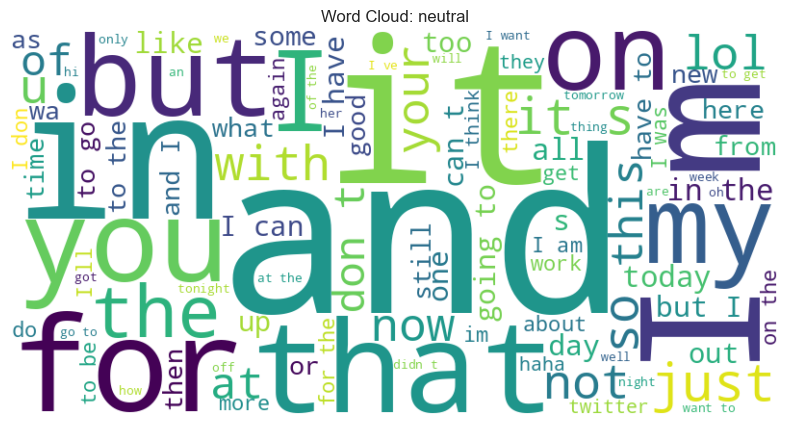

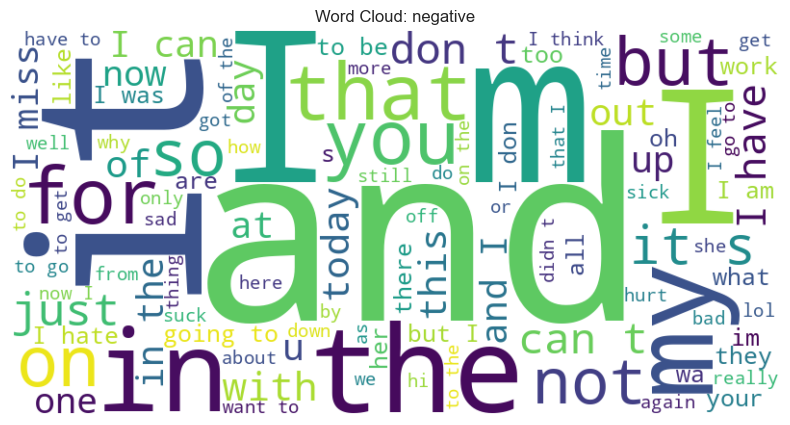

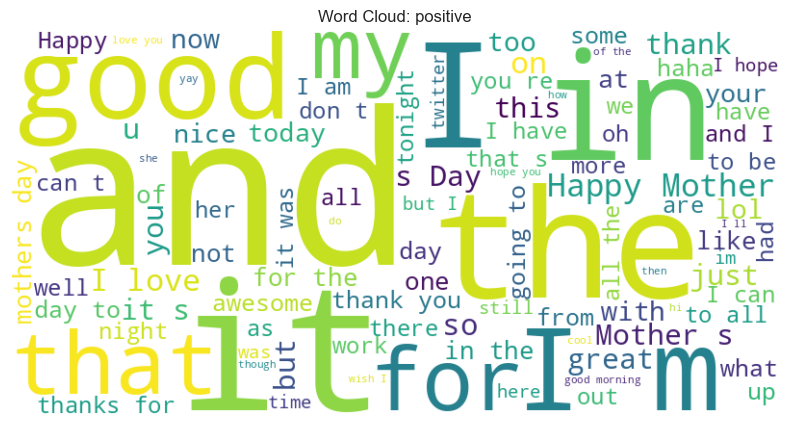

In [9]:
# Creamos un conjunto de palabras vacías (stopwords) en español, para que no aparezcan en las nubes de palabras
stop_spanish = set(stopwords.words('spanish'))

# Iteramos por cada valor único de la columna 'sentiment' (por ejemplo: positivo, negativo, neutral)
for sentiment in df['sentiment'].unique():
    # Unimos todos los textos que tienen ese mismo sentimiento en un solo string grande
    texts = " ".join(df[df['sentiment'] == sentiment]['text'])

    # Creamos un objeto WordCloud, configurado para:
    # - Eliminar las stopwords
    # - Fondo blanco
    # - Máximo 100 palabras
    # - Dimensiones del gráfico: 800x400 píxeles
    cloud = WordCloud(stopwords=stop_spanish, background_color='white', max_words=100, width=800, height=400)

    # Creamos una nueva figura de tamaño 10x5 pulgadas para visualizar la nube
    plt.figure(figsize=(10, 5))

    # Generamos e insertamos la nube de palabras basada en los textos para ese sentimiento
    plt.imshow(cloud.generate(texts), interpolation='bilinear')

    # Quitamos los ejes para que solo se vea la nube
    plt.axis('off')

    # Le damos un título a la imagen que indica el sentimiento representado
    plt.title(f"Word Cloud: {sentiment}")

    # Mostramos la nube en pantalla
    plt.show()


## Limpieza del texto (Preprocesamiento)

Vamos a limpiar los tuits:
* Quitar menciones @usuario
* Quitar hashtags y URLs
* Quitar puntuación y números
* Pasar a minúsculas
* Eliminar stopwords (en inglés)
* (Opcional) Lemmatizar



In [10]:
# Importamos la biblioteca 're' para trabajar con expresiones regulares,
# útil para limpiar texto (por ejemplo, eliminar URLs, menciones, etc.)
import re

# Importamos 'string' para acceder a símbolos como puntuación y caracteres especiales
# que queremos eliminar del texto

# Importamos la lista de stopwords (palabras vacías como "el", "y", "de") del corpus de NLTK
from nltk.corpus import stopwords

# Importamos el lematizador WordNetLemmatizer, que permite reducir palabras a su forma base o "lema"
# Por ejemplo, "corriendo" → "correr", "mejores" → "mejor"
from nltk.stem import WordNetLemmatizer

# Descargamos el diccionario WordNet necesario para el proceso de lematización
nltk.download('wordnet')

# Descargamos soporte multilingüe para WordNet, que mejora el proceso de lematización
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jresendiz/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/jresendiz/nltk_data...


True

In [11]:
# Creamos un conjunto de stopwords en inglés para filtrar palabras vacías comunes como "the", "and", "is", etc.
stop_words = set(stopwords.words('english'))

# Creamos una instancia del lematizador WordNetLemmatizer, que convertirá las palabras a su forma base
lemmatizer = WordNetLemmatizer()


# Definimos una función para limpiar el texto y dejarlo listo para análisis o modelado
def clean_text(text):
    # Convertimos todo el texto a minúsculas para evitar que palabras como "Good" y "good" se consideren distintas
    text = text.lower()

    # Eliminamos menciones de usuarios (como @usuario) usando una expresión regular
    text = re.sub(r"@[\w_]+", "", text)

    # Eliminamos URLs (cualquier cosa que empiece con http o www)
    text = re.sub(r"http\S+|www.\S+", "", text)

    # Quitamos signos de puntuación (como !, ?, ., etc.)
    text = re.sub(r"[^\w\s]", "", text)

    # Quitamos números del texto
    text = re.sub(r"\d+", "", text)

    # Dividimos el texto en palabras individuales (tokens)
    tokens = text.split()

    # Lematizamos cada palabra y eliminamos las que estén en la lista de stopwords
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    # Unimos los tokens de nuevo en una sola cadena de texto limpia
    return " ".join(tokens)


In [12]:
df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()

,text,clean_text
0,"I`d have responded, if I were going",id responded going
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad miss san diego
2,my boss is bullying me...,bos bullying
3,what interview! leave me alone,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",son couldnt put release already bought


In [13]:
#vamos a verificar resultados
print("Original:")
print(df['text'].iloc[0])
print("\nLimpio:")
print(df['clean_text'].iloc[0])


Original:
 I`d have responded, if I were going

Limpio:
id responded going


## Extracción de características

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [15]:
# Creamos una instancia de LabelEncoder, que sirve para convertir etiquetas de texto (como "positivo", "negativo")
# en números (como 1 y 0), lo cual es necesario para entrenar modelos de machine learning
encoder = LabelEncoder()

# Aplicamos el encoder a la columna 'sentiment' y guardamos los valores codificados en una nueva columna llamada 'label'
# Por ejemplo: "negativo" → 0, "positivo" → 1
df['label'] = encoder.fit_transform(df['sentiment'])

# Dividimos el dataset en conjunto de entrenamiento y prueba
# X serán los textos ya limpiados (columna 'clean_text') y y serán las etiquetas numéricas (columna 'label')
# El 20% de los datos se reservarán para prueba (test), y el resto para entrenamiento (train)
# random_state=42 garantiza que la división sea siempre igual si se repite el código
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)


Bag of Words (BoW)

In [16]:
# Importamos la clase CountVectorizer de sklearn, que permite convertir texto en vectores numéricos
from sklearn.feature_extraction.text import CountVectorizer

# Creamos el vectorizador usando unigramas (palabras individuales) y bigramas (pares de palabras consecutivas)
vectorizer_bow = CountVectorizer(ngram_range=(1, 2))  # ngram_range=(1,2) incluye unigramas y bigramas

X_train_bow = vectorizer_bow.fit_transform(
    X_train)  # Ajustamos el vectorizador al conjunto de entrenamiento (aprende el vocabulario y crea la matriz BoW)
X_test_bow = vectorizer_bow.transform(
    X_test)  # Transformamos el conjunto de prueba usando el mismo vocabulario aprendido del conjunto de entrenamiento




In [17]:
print(X_train_bow)

  (0, 77188)	1
  (0, 47549)	2
  (0, 49276)	1
  (0, 52809)	1
  (0, 20328)	1
  (0, 33210)	1
  (0, 72291)	1
  (0, 77282)	1
  (0, 47597)	1
  (0, 49283)	1
  (0, 52938)	1
  (0, 20329)	1
  (0, 33218)	1
  (0, 47618)	1
  (1, 105699)	1
  (1, 111936)	1
  (1, 50675)	1
  (1, 14356)	1
  (1, 111549)	1
  (1, 34622)	1
  (1, 122819)	1
  (1, 50306)	1
  (1, 45165)	1
  (1, 49619)	1
  (1, 105974)	1
  :	:
  (21980, 115280)	1
  (21980, 10578)	1
  (21980, 38027)	1
  (21980, 115301)	1
  (21981, 89900)	1
  (21981, 17275)	1
  (21981, 35535)	1
  (21981, 114706)	1
  (21981, 35548)	1
  (21981, 114707)	1
  (21981, 89906)	1
  (21982, 107505)	1
  (21982, 30000)	1
  (21982, 30004)	1
  (21983, 95132)	1
  (21983, 64337)	1
  (21983, 43415)	1
  (21983, 77037)	1
  (21983, 86434)	1
  (21983, 18777)	1
  (21983, 64763)	1
  (21983, 95190)	1
  (21983, 18779)	1
  (21983, 43706)	1
  (21983, 77073)	1


TF - IDF

In [18]:
from sklearn.feature_extraction.text import \
    TfidfVectorizer  # Importamos TfidfVectorizer, que convierte texto en vectores usando el peso TF-IDF

vectorizer_tfidf = TfidfVectorizer(ngram_range=(
1, 2))  # Creamos el vectorizador configurado para usar unigramas (palabras individuales) y bigramas (pares de palabras)
X_train_tfidf = vectorizer_tfidf.fit_transform(
    X_train)  # Ajustamos el vectorizador al texto de entrenamiento y transformamos ese texto en una matriz TF-IDF
X_test_tfidf = vectorizer_tfidf.transform(
    X_test)  # Transformamos el texto de prueba utilizando el mismo vocabulario y pesos aprendidos en el entrenamiento



Bi-gramas

In [19]:
from sklearn.feature_extraction.text import \
    CountVectorizer  # Importamos CountVectorizer, que convierte texto en vectores de conteo (frecuencia de palabras o n-gramas)

bigram_vectorizer = CountVectorizer(ngram_range=(
2, 2))  # Creamos un vectorizador configurado para extraer únicamente bigramas (pares consecutivos de palabras)
# ngram_range=(2, 2) significa que solo se tomarán bigramas, no unigramas ni trigramas
X_train_bigram = bigram_vectorizer.fit_transform(
    X_train)  # Ajustamos el vectorizador con los textos de entrenamiento y transformamos esos textos en una matriz BoW de bigramas
X_test_bigram = bigram_vectorizer.transform(
    X_test)  # Transformamos los textos de prueba usando el mismo vocabulario de bigramas aprendido del conjunto de entrenamiento



## Entrenamiento

Entrenamiento: Árbol de decisión y SVM

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Árbol con TF-IDF
tree = DecisionTreeClassifier(
    random_state=0)  # Creamos una instancia del modelo de árbol de decisión y establecemos random_state=0 para que los resultados sean reproducibles
tree.fit(X_train_tfidf,
         y_train)  # Entrenamos el modelo usando los vectores TF-IDF del conjunto de entrenamiento y sus etiquetas

# SVM con BoW
svm = SVC(
    kernel='linear')  # Creamos una instancia del clasificador SVM con un kernel lineal y El kernel lineal es ideal para problemas de clasificación linealmente separables
svm.fit(X_train_bow,
        y_train)  # Entrenamos el modelo con los vectores de texto obtenidos mediante Bag of Words (BoW) y sus etiquetas

#Arbol con Bigramas
tree_bigram = DecisionTreeClassifier(
    random_state=42)  # Creamos una instancia del modelo con una semilla aleatoria fija (para resultados reproducibles)
tree_bigram.fit(X_train_bigram,
                y_train)  # Entrenamos el árbol usando los vectores de texto basados únicamente en bigramas y X_train_bigram contiene la matriz de frecuencia de bigramas generada previamente


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Evaluación

## Embeddings

Ahora hagamoslo con Wor2Vec y GloVe

In [27]:
# import gensim.downloader as api
# import numpy as np
#
# # Descargar modelo GloVe de 50 dimensiones
# glove_model = api.load("glove-wiki-gigaword-50")
#
# # Función alternativa sin nltk
# def vectorize_text_simple(texts, model, vector_size=50):
#     vectors = []
#     for text in texts:
#         tokens = text.lower().split()  # tokeniza en minúsculas
#         word_vectors = [model[word] for word in tokens if word in model]  # solo palabras conocidas
#         if word_vectors:
#             avg_vector = np.mean(word_vectors, axis=0)  # vector promedio del texto
#         else:
#             avg_vector = np.zeros(vector_size)  # vector nulo si no hay palabras válidas
#         vectors.append(avg_vector)
#     return np.array(vectors)  # devuelve matriz de vectores
#
# # Ejecutamos sobre los datos
# X_train_glove = vectorize_text_simple(X_train, glove_model)  # vectores promedio GloVe para entrenamiento
# X_test_glove = vectorize_text_simple(X_test, glove_model)    # vectores promedio GloVe para prueba
#


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# # Usamos Decision Tree (aunque puedes probar otros como SVM o LogisticRegression)
# tree_glove = DecisionTreeClassifier(random_state=0)  # modelo árbol con semilla fija
# tree_glove.fit(X_train_glove, y_train)  # entrena con vectores GloVe
#


DecisionTreeClassifier(random_state=0)

In [ ]:
# y_pred_glove = tree_glove.predict(X_test_glove)  # predicción con árbol y GloVe
# print("Árbol con GloVe (Word Embeddings)")  # título
# print(confusion_matrix(y_test, y_pred_glove))  # matriz de confusión
# print(classification_report(y_test, y_pred_glove, target_names=encoder.classes_))  # métricas por clase
#


Árbol con GloVe (Word Embeddings)
[[ 615  597  360]
 [ 593 1056  587]
 [ 317  547  824]]
              precision    recall  f1-score   support

    negative       0.40      0.39      0.40      1572
     neutral       0.48      0.47      0.48      2236
    positive       0.47      0.49      0.48      1688

    accuracy                           0.45      5496
   macro avg       0.45      0.45      0.45      5496
weighted avg       0.45      0.45      0.45      5496



In [25]:
# Apliquemos GridSearchCV para DecisionTree(Bow), RandomForest(TFIDF), LogisticRegression(TFIDF), GradientBoosting(n-grams)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# LogisticRegression with TFIDF
import time

start = time.time()
print("Starting LogisticRegression training")
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [200, 350]
}
lr_tfidf_estimator = LogisticRegression()
lr_tfidf = GridSearchCV(
    estimator=lr_tfidf_estimator,
    param_grid=lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
lr_tfidf.fit(X_train_tfidf, y_train)
print(f"Finished training for LogisticRegression(TFIDF). Time: {(time.time() - start)} seconds")


Starting LogisticRegression training
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Finished training for LogisticRegression(TFIDF). Time: 59.93684697151184 seconds


In [29]:
# DecisionTreeeWithBoW
start = time.time()
print("Starting DecisionTreeClassifier training")
dtree_param_grid = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}
dtree_bow_estimator = DecisionTreeClassifier(random_state=0)
dtree_bow = GridSearchCV(
    estimator=dtree_bow_estimator,
    param_grid=dtree_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
dtree_bow.fit(X_train_bow, y_train)
print(f"Finished training for DecisionTreeClassifier(BoW). Time: {(time.time() - start)} seconds")

Starting DecisionTreeClassifier training
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/jresendiz/miniconda3/envs/CIC_AIDiploma2025/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jresendiz/miniconda3/envs/CIC_AIDiploma2025/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/jresendiz/miniconda3/envs/CIC_AIDiploma2025/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for rem

Finished training for DecisionTreeClassifier(BoW). Time: 320.44581508636475 seconds


In [30]:
# RandomForest(TFIDF)
start = time.time()
print("Starting RandomForestClassifier")
rf_param_grid = {
    'n_estimators': [20, 30],
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
rf_tfidf_estimator = RandomForestClassifier(random_state=0)
rf_tfidf = GridSearchCV(
    estimator=rf_tfidf_estimator,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)
rf_tfidf.fit(X_train_tfidf, y_train)
print(f"Finished training for RandomForestClassifier(TFIDF). Time: {(time.time() - start)} seconds")

Starting RandomForestClassifier
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 3/5] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2;, score=0.475 total time=   2.9s
[CV 5/5] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=3;, score=0.479 total time=   3.2s
[CV 3/5] END criterion=gini, max_depth=3, min_samples_leaf=2, min_samples_split=3;, score=0.475 total time=   2.9s
[CV 1/5] END criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=3;, score=0.478 total time=   3.0s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2;, score=0.501 total time=   3.3s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2;, score=0.494 total time=   3.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=3, min_samples_split=2;, score=0.505 total time=   3.1s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=3, min_samples_split=3;, score=0.504 total

In [32]:
# GradientBoosting(n-grams)
start = time.time()
print("Starting GradientBoostingClassifier")
gb_param_grid = {
    'n_estimators': [20, 30],
    'max_depth': [2, 3],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'learning_rate': [0.01, 0.1],
}
gb_ngram_estimator = GradientBoostingClassifier(random_state=0)
gb_ngram = GridSearchCV(
    estimator=gb_ngram_estimator,
    cv=5,
    param_grid=gb_param_grid,
    n_jobs=-1,
    verbose=3
)
gb_ngram.fit(X_train_bigram, y_train)
print(f"Finished training for GradientBoostingClassifier(BiGram). Time: {(time.time() - start)} seconds")

Starting GradientBoostingClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits

[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=2, n_estimators=30;, score=0.411 total time=   1.3s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=3, n_estimators=20;, score=0.414 total time=   0.9s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=3, n_estimators=20;, score=0.414 total time=   0.9s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=3, n_estimators=30;, score=0.414 total time=   1.3s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=3, n_estimators=30;, score=0.414 total time=   1.3s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.674 total time=

In [34]:
# Validar el resto de los modelos
from sklearn.metrics import classification_report, confusion_matrix

# DecisionTree(BoW)
print("DecisionTree con TF-IDF")
y_pred_tree = dtree_bow.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree, target_names=encoder.classes_))

# SVM con BoW
y_pred_svm = svm.predict(X_test_bow)
print("SVM con BoW")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=encoder.classes_))

# DecisionTree con Bigramas
y_pred_bigram = tree_bigram.predict(X_test_bigram)
print("DecisionTree con Bigramas")
print(confusion_matrix(y_test, y_pred_bigram))
print(classification_report(y_test, y_pred_bigram, target_names=encoder.classes_))

# DecisionTree(Bow)
y_pred_dt_bow = dtree_bow.predict(X_test_bow)
print("DecisionTree con BoW")
print(confusion_matrix(y_test, y_pred_dt_bow))
print(classification_report(y_test, y_pred_dt_bow, target_names=encoder.classes_))

# RandomForest(TFIDF)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
print("RandomForest con TFIDF")
print(confusion_matrix(y_test, y_pred_rf_tfidf))
print(classification_report(y_test, y_pred_rf_tfidf, target_names=encoder.classes_))

# LogisticRegression(TFIDF)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
print("LogisticRegression con TFIDF")
print(confusion_matrix(y_test, y_pred_lr_tfidf))
print(classification_report(y_test, y_pred_lr_tfidf, target_names=encoder.classes_))

# GradientBoosting(n-grams)
y_pred_gb_ngram = gb_ngram.predict(X_test_bigram)
print("GradientBoosting con BiGramas")
print(confusion_matrix(y_test, y_pred_gb_ngram))
print(classification_report(y_test, y_pred_gb_ngram, target_names=encoder.classes_))

DecisionTree con TF-IDF
[[ 128 1430   14]
 [  55 2159   22]
 [  17 1569  102]]
              precision    recall  f1-score   support

    negative       0.64      0.08      0.14      1572
     neutral       0.42      0.97      0.58      2236
    positive       0.74      0.06      0.11      1688

    accuracy                           0.43      5496
   macro avg       0.60      0.37      0.28      5496
weighted avg       0.58      0.43      0.31      5496

SVM con BoW
[[ 946  521  105]
 [ 335 1636  265]
 [  83  368 1237]]
              precision    recall  f1-score   support

    negative       0.69      0.60      0.64      1572
     neutral       0.65      0.73      0.69      2236
    positive       0.77      0.73      0.75      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496

DecisionTree con Bigramas
[[ 413 1069   90]
 [ 210 1822  204]
 [  84  940  664]]
           

## Vamos a comparar todos

In [36]:
from sklearn.metrics import accuracy_score, f1_score

def evaluar_modelo(nombre, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'Modelo': nombre, 'Accuracy': acc, 'F1 Score': f1}


resultados = [
    evaluar_modelo("Árbol + TF-IDF", y_test, y_pred_tree),
    evaluar_modelo("SVM + BoW", y_test, y_pred_svm),
    evaluar_modelo("Árbol + Bigramas", y_test, y_pred_bigram),
    evaluar_modelo("DecisionTree + BoW", y_test, y_pred_dt_bow),
    evaluar_modelo("RandomForest + TF-IDF", y_test, y_pred_rf_tfidf),
    evaluar_modelo("LogisticRegression + TF-IDF", y_test, y_pred_lr_tfidf),
    evaluar_modelo("GradientBoosting + Bigrams", y_test, y_pred_gb_ngram),
]

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1 Score', ascending=False)

# Actualizar DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by='F1 Score', ascending=False)



,Modelo,Accuracy,F1 Score
1,SVM + BoW,0.694869,0.694527
5,LogisticRegression + TF-IDF,0.690684,0.690209
4,RandomForest + TF-IDF,0.686681,0.685058
3,DecisionTree + BoW,0.668304,0.668179
2,Árbol + Bigramas,0.527475,0.502173
6,GradientBoosting + Bigrams,0.458151,0.352282
0,Árbol + TF-IDF,0.434680,0.313225


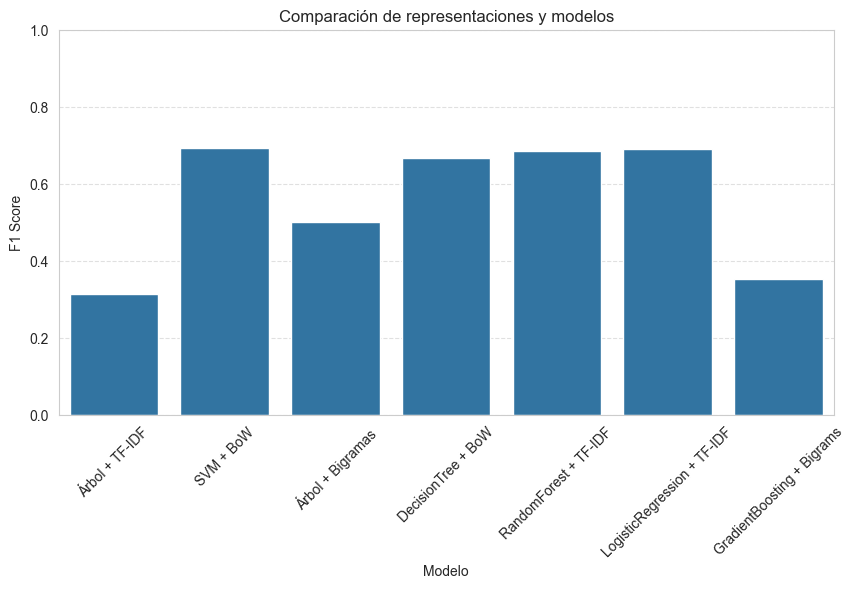

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x='Modelo', y='F1 Score')
plt.title("Comparación de representaciones y modelos")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()
